# Convolutional Neural Networks

## Preliminaries

In this practical session you will implement and train several Convolutional Neural Networks (CNNs) using the Keras framework with a Tensorflow backend. If you are not already familiar with Keras, you can go over the [following tutorial](https://github.com/tueimage/essential-skills/blob/master/keras.md). More detailed information on the different functionalities can be found in the [Keras library documentation](https://keras.io/). 

Note that for this set of exercise CPU-only Tensorflow, which you should already have installed, is sufficient (i.e. GPU-support is not required but it will make your experiments run faster). 

You are also required to use the `gryds` package for data augmentation that you can install directly from git: `pip install git+https://github.com/tueimage/gryds/`.

You also have to install the Keras deep learning framework (if you have not done so already) by running `conda install keras`. Note that there are two implementations of Keras, one from https://keras.io/ and another one that ships with Tensorflow. Here we use the former. 

## MNIST
We will first train a simple CNN to classify handwritten digits using the MNIST dataset. This dataset is often referred to as the "Hello world!" example of deep learning because it can be used to quickly illustrate a small neural network in action (and obtain a decent classification accuracy in the process). More information on it can be found [here](http://yann.lecun.com/exdb/mnist/).

First, let's load the dataset and visualize some images.

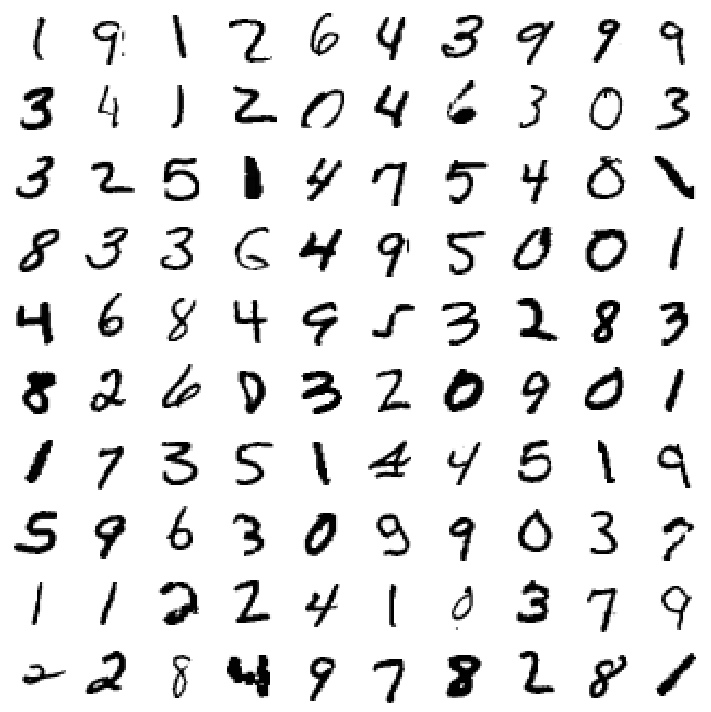

In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

# load the MNIST the dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# scale the image intensities to the 0-1 range
x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

# convert the data to channel-last
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# convert the labels to one-hot encoded
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

def plot_images(images, dim=(10, 10), figsize=(10, 10), title=''):
    
    plt.figure(figsize=figsize)
    
    for i in range(images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(images[i], interpolation='nearest', cmap='gray_r')
        plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(title)
    plt.show()
    
plot_images(x_train[np.random.randint(0, x_train.shape[0], size=100)].reshape(100, 28, 28))

The MNIST classification task is quite simple: given an image, predict the digit that it contains. Thus, this is a 10-class classification problem.

Let's define a simple network for the handwritten digit classification.

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 12, 12, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 12, 12, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 9216)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               1179776   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

Compile and train the network (note that this could take a while).

In [6]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam

model.compile(loss=categorical_crossentropy, optimizer=Adam(), metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=128,
          epochs=12,
          verbose=1,
          validation_data=(x_test, y_test))

score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Epoch 1/12
469/469 [==============================] - 54s 115ms/step - loss: 0.2486 - accuracy: 0.9240 - val_loss: 0.0567 - val_accuracy: 0.9814
Epoch 2/12
469/469 [==============================] - 53s 113ms/step - loss: 0.0899 - accuracy: 0.9736 - val_loss: 0.0382 - val_accuracy: 0.9868
Epoch 3/12
469/469 [==============================] - 53s 112ms/step - loss: 0.0672 - accuracy: 0.9796 - val_loss: 0.0352 - val_accuracy: 0.9880
Epoch 4/12
469/469 [==============================] - 60s 128ms/step - loss: 0.0550 - accuracy: 0.9832 - val_loss: 0.0326 - val_accuracy: 0.9891
Epoch 5/12
469/469 [==============================] - 53s 112ms/step - loss: 0.0462 - accuracy: 0.9858 - val_loss: 0.0300 - val_accuracy: 0.9904
Epoch 6/12
469/469 [==============================] - 65s 139ms/step - loss: 0.0408 - accuracy: 0.9870 - val_loss: 0.0345 - val_accuracy: 0.9880
Epoch 7/12
469/469 [==============================] - 54s 115ms/step - loss: 0.0378 - accuracy: 0.9883 - val_loss: 0.0305 - val_ac

Now that the model is trained, we can evaluate its performance on the independent test dataset.

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.02808692306280136
Test accuracy: 0.9912999868392944


## U-Net
The U-Net convolutional neural network architecture was first developed for biomedical image segmentation and is to this day one of the most widely used methods for image segmentation. The details of the architecture can be found in the [original paper](https://arxiv.org/abs/1505.04597). In this practical we will build and train a U-Net network that is able to segment blood vessels in retinal images. 

### Loading and visualizing the data
The data for this task is taken from the [DRIVE](https://www.isi.uu.nl/Research/Databases/DRIVE/index.php) database. It consists of photographs of the retina, where the goal is to segment the blood vessels within. The dataset has a total of 40 photographs, divided in 20 images for training and 20 for testing. 

Let's load the training set and visualize an image with the corresponding blood vessel segmentation. For training we will divide the data in a training and a validation set to monitor the model during training.

(20, 584, 565, 3)
(20, 584, 565, 1)


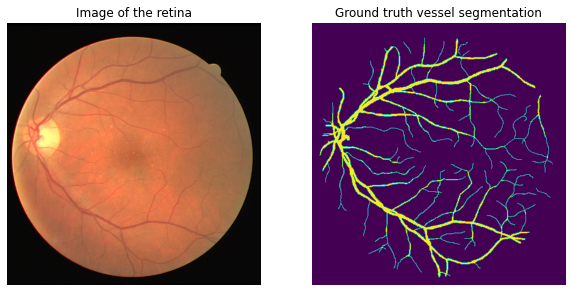

(16, 584, 565, 3)
(16, 584, 565, 1)
(16, 584, 565, 1)
(4, 584, 565, 3)
(4, 584, 565, 1)
(4, 584, 565, 1)


In [11]:
%matplotlib inline
import sys
sys.path.append('./code/')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from unet_utils import load_data

# location of the DRIVE dataset
data_folder = './data/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# print the shape of image dataset
print(images.shape)
print(segmentations.shape)



plt.figure(figsize=(10, 8))

plt.subplot(1, 2, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(images[0])

plt.subplot(1, 2, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
segmentations[0]
plt.imshow(segmentations[0][:, :, 0])
plt.show()

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)

# print the shape of the training and valudation datasets
print(train_images.shape)
print(train_masks.shape)
print(train_segmentations.shape)
print(val_images.shape)
print(val_masks.shape)
print(val_segmentations.shape)

### Training a U-Net model

You are already provided with implementation of the U-Net architecture in `unet_model.py`. This is a modular implementation and can be used to generate U-Net architectures with a variety of hyperparameters such as depth and number of feature maps. Before using the model, examine the code and documentation and make sure that you understand all the details.

We will train a U-Net model using smaller patches extracted from the training images. Training the images on smaller patches requires less computation power and results in a more varied training dataset (it has the effect of data augmentation by image translation). Because a U-Net is a fully convolutional network it can be evaluated on inputs of different size (the output size will change according to the input size). Thus, although the model will be trained on smaller patches it can still be used to segment larger images with one pass through the model. 


(16, 32, 32, 3)


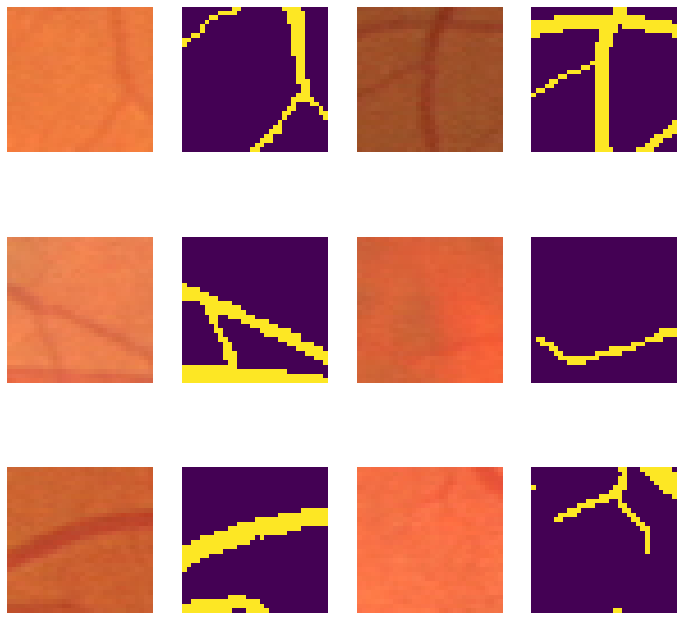

In [12]:
from unet_utils import extract_patches, preprocessing

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# visualize a couple of patches as a visual check
patches, patches_segmentations = extract_patches(train_images, train_segmentations, patch_size, patches_per_im=1, seed=7)

print(patches.shape)

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(12, 12))

for i in range(0, 3):
    axes[i, 0].axis('off')
    axes[i, 0].imshow(patches[i])
    axes[i, 1].axis('off')
    axes[i, 1].imshow(patches_segmentations[i][:, :, 0])
    axes[i, 2].axis('off')
    axes[i, 2].imshow(patches[i+5])
    axes[i, 3].axis('off')
    axes[i, 3].imshow(patches_segmentations[i+5][:, :, 0])

plt.show()

In [13]:
# pad the validation data to fit the U-Net model
# images of shape (584, 565) shape result in concatenation error due to the odd number of columns

print("Old shape:", val_images.shape)

val_images, val_masks, val_segmentations = preprocessing(
    val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
    
print("New shape:", val_images.shape)

Old shape: (4, 584, 565, 3)
New shape: (4, 584, 584, 3)


In [14]:
import os
from unet_model import unet
from unet_utils import datagenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import pandas as pd
import _pickle as cPickle

# use a single training image, to better demonstrate the effects of data augmentation
X_train, y_train = np.expand_dims(train_images[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)

print(X_train.shape)
print(y_train.shape)

# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))

# work with 32x32 patches
patch_size = (32, 32)
# 200 patches per image
patches_per_im = 200

# initialize model
model = unet(input_shape=(None, None, 3), depth=depth, channels=channels, batchnorm=use_batchnorm)

# print a summary of the model
# model.summary(line_length=120)

# compile the model
model.compile(loss='binary_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model.fit_generator(datagenerator(X_train, y_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])
#save baseline model
with open('history_baseline', 'wb') as file_pi:
         
        cPickle.dump(history.history, file_pi)
del history

model.save('partly_trained.h5')

(1, 584, 565, 3)
(1, 584, 565, 1)
Epoch 1/250
50/50 - 45s - loss: 0.5348 - accuracy: 0.8134 - val_loss: 0.4159 - val_accuracy: 0.9211
Epoch 2/250
50/50 - 44s - loss: 0.3151 - accuracy: 0.9482 - val_loss: 0.2859 - val_accuracy: 0.9211
Epoch 3/250
50/50 - 61s - loss: 0.2172 - accuracy: 0.9563 - val_loss: 0.3000 - val_accuracy: 0.9211
Epoch 4/250
50/50 - 45s - loss: 0.1716 - accuracy: 0.9603 - val_loss: 0.3101 - val_accuracy: 0.9211
Epoch 5/250
50/50 - 60s - loss: 0.1706 - accuracy: 0.9543 - val_loss: 0.2747 - val_accuracy: 0.9214
Epoch 6/250
50/50 - 51s - loss: 0.1367 - accuracy: 0.9606 - val_loss: 0.3148 - val_accuracy: 0.9206
Epoch 7/250
50/50 - 49s - loss: 0.1422 - accuracy: 0.9584 - val_loss: 0.3214 - val_accuracy: 0.8951
Epoch 8/250
50/50 - 50s - loss: 0.1358 - accuracy: 0.9578 - val_loss: 0.2976 - val_accuracy: 0.9209
Epoch 9/250
50/50 - 32s - loss: 0.1164 - accuracy: 0.9624 - val_loss: 0.3173 - val_accuracy: 0.9261
Epoch 10/250
50/50 - 32s - loss: 0.1114 - accuracy: 0.9626 - val_l

### Visualizing the segmentation results

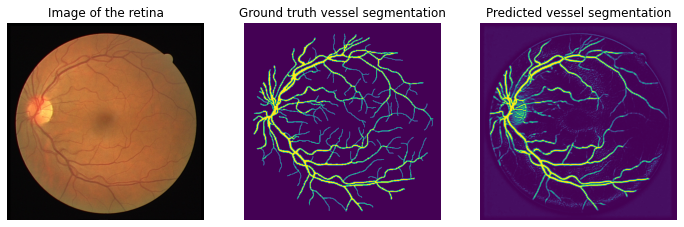

In [15]:
# run the model on one test image and show the results
from unet_utils import preprocessing

# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

# predict test samples
test_prediction = model.predict(X_test, batch_size=4)

# visualize the test result
plt.figure(figsize=(12, 10))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(test_images[0])

plt.subplot(1, 3, 2)
plt.title("Ground truth vessel segmentation")
plt.axis('off')
plt.imshow(test_segmentations[0][:, :, 0])

plt.subplot(1, 3, 3)
plt.title("Predicted vessel segmentation")
plt.axis('off')
plt.imshow(test_prediction[0, :, :, 0])

plt.show()

# Exercises

## Number of parameters

The first convolutional layer in the MNIST example has 320 parameters. The first fully connected layer has 1179,776 parameters. What do these parameters correspond to? 

<font color='#770a0a'>What is the general expression for the number of parameters of 1) a convolutional layer and 2) a fully-connected layer?</font>

## Fully-convolutional MNIST model

Modify the model in the MNIST example in such a way that it only contains convolutional layers while keeping the same number of parameters. If you do the modification correctly, the two models will have the same behaviour (i.e. they will represent the same model, only with different implementation). Show this experimentally. 


## U-Net architecture

<font color='#770a0a'> What is the role of the skip connections in the U-Net neural network architecture? Will it be possible to train the exact same architecture with the skip connections omitted? If yes, what would be the expected result? If no, what would be the cause of the error?</font>

## Data augmentation

<font color='#770a0a'>Why does data augmentation result in less overfitting? Can data augmentation be applied to the test samples? If yes, towards what goal? If no, what is preventing that?</font>


Implement random brightness augmentation of the image data by adding a random offset to the image intensity before passing them trough the network at training time. Train a model with random brightness augmentation and compare it to the baseline above. 

Implement data augmentation procedure that in addition to brightness augmentation also performs b-spline geometric augmentation using the [`gryds`](https://github.com/tueimage/gryds) package (you can look at the documentation of the package for an example on how to do that). Compare the new model with the baseline and the model that only performs brightness augmentation.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


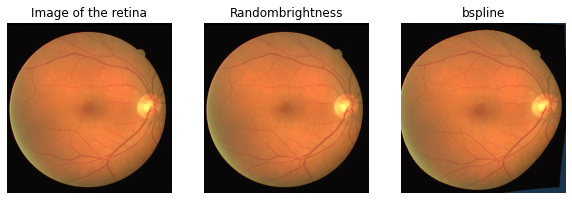

Epoch 1/250
50/50 - 33s - loss: 0.1057 - accuracy: 0.9627 - val_loss: 0.3353 - val_accuracy: 0.9178
Epoch 2/250
50/50 - 38s - loss: 0.0975 - accuracy: 0.9651 - val_loss: 0.1431 - val_accuracy: 0.9496
Epoch 3/250
50/50 - 36s - loss: 0.1014 - accuracy: 0.9637 - val_loss: 0.3266 - val_accuracy: 0.8544
Epoch 4/250
50/50 - 43s - loss: 0.0978 - accuracy: 0.9642 - val_loss: 0.2940 - val_accuracy: 0.8927
Epoch 5/250
50/50 - 33s - loss: 0.0952 - accuracy: 0.9652 - val_loss: 0.4905 - val_accuracy: 0.8262
Epoch 6/250
50/50 - 32s - loss: 0.0957 - accuracy: 0.9645 - val_loss: 0.1541 - val_accuracy: 0.9489
Epoch 7/250
50/50 - 33s - loss: 0.0929 - accuracy: 0.9656 - val_loss: 0.1703 - val_accuracy: 0.9423
Epoch 8/250
50/50 - 42s - loss: 0.0940 - accuracy: 0.9655 - val_loss: 0.2786 - val_accuracy: 0.8938
Epoch 9/250
50/50 - 33s - loss: 0.0887 - accuracy: 0.9671 - val_loss: 0.2695 - val_accuracy: 0.9139
Epoch 10/250
50/50 - 33s - loss: 0.0888 - accuracy: 0.9666 - val_loss: 0.1551 - val_accuracy: 0.9503

In [16]:
%matplotlib inline
import sys
sys.path.append('./code/')
sys.path.append('./gryds/')
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from glob import glob
from augmentation import brightness_aug,bspline_aug
from unet_utils import load_data
from unet_utils import extract_patches, preprocessing
# from tensorflow.image import random_brightness
import tensorflow as tf



# location of the DRIVE dataset
data_folder = './data/DRIVE/'
train_paths = glob(data_folder + 'training/images/*.tif')
images, masks, segmentations = load_data(train_paths)

# divide in training and validation
train_images, val_images, train_masks, val_masks, train_segmentations, val_segmentations = train_test_split(
    images, masks, segmentations, test_size=0.2, random_state=7)


#brightness data augmentation 
brightness_aug_list=brightness_aug(train_images,0.2)

#Bspline data augmentation


bspline_aug_list,bspline_aug_list_seg=bspline_aug(train_images,train_segmentations)

#example train_image vs training image with randombrightness 
plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)
plt.title("Image of the retina")
plt.axis('off')
plt.imshow(train_images[0])

plt.subplot(1, 3, 2)
plt.title("Randombrightness")
plt.axis('off')
plt.imshow(brightness_aug_list[0])

plt.subplot(1, 3, 3)
plt.title("bspline")
plt.axis('off')
plt.imshow(bspline_aug_list[0])

plt.show()

###Training the baseline model and extend training with rondom brightness augmented images. 

model_2 = tf.keras.models.load_model('partly_trained.h5')

# work with 32x32 patches
patch_size = (32, 32)

# 200 patches per image
patches_per_im = 200

# pad the data to fit the U-Net model
val_images, val_masks, val_segmentations = preprocessing( val_images, 
    val_masks, 
    val_segmentations, 
    desired_shape=(584, 584))
# use a single image to evaluate
Xa_train, ya_train = np.expand_dims(brightness_aug_list[0], axis=0), np.expand_dims(train_segmentations[0], axis=0)
Xb_train, yb_train = np.expand_dims(bspline_aug_list[0], axis=0), np.expand_dims(bspline_aug_list_seg[0], axis=0)
# hyperparameters
depth = 3
channels = 32
use_batchnorm = True
batch_size = 64
epochs = 250
steps_per_epoch = int(np.ceil((patches_per_im * len(train_images)) / batch_size))




# stop the training if the validation loss does not increase for 15 consecutive epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# train the model with the data generator, and save the training history
history = model_2.fit_generator(datagenerator(Xa_train, ya_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

##save baselinemodel+brightness augmentation 
with open('history_baseline_aug1', 'wb') as file_pi:
        cPickle.dump(history.history, file_pi)

del history
model_2.save('model_bright.h5')
del model_2

model_3=tf.keras.models.load_model('model_bright.h5')

history = model_3.fit_generator(datagenerator(Xb_train, yb_train, patch_size, patches_per_im, batch_size),
                              validation_data=(val_images, val_segmentations),
                              steps_per_epoch=steps_per_epoch, epochs=epochs, verbose=2,
                              callbacks=[early_stopping])

##save baselinemodel+brightness augmentation 
with open('history_baseline_aug1_aug2', 'wb') as file_pi:
        cPickle.dump(history.history, file_pi)

del history

##save baselinemodel+brightness augmentation+bspline augmentation
model_3.save('model_bright_bspline.h5')

## run the model on one test image and show the results
# test data paths
impaths_test = glob(data_folder + 'test/images/*.tif')

# load data
test_images, test_masks, test_segmentations = load_data(impaths_test, test=True)

# pad the data to fit the U-Net model
test_images, test_masks, test_segmentations = preprocessing(test_images, test_masks, test_segmentations, 
                                                            desired_shape=(584, 584))

# use a single image to evaluate
X_test, y_test = np.expand_dims(test_images[0], axis=0), np.expand_dims(test_masks[0], axis=0)

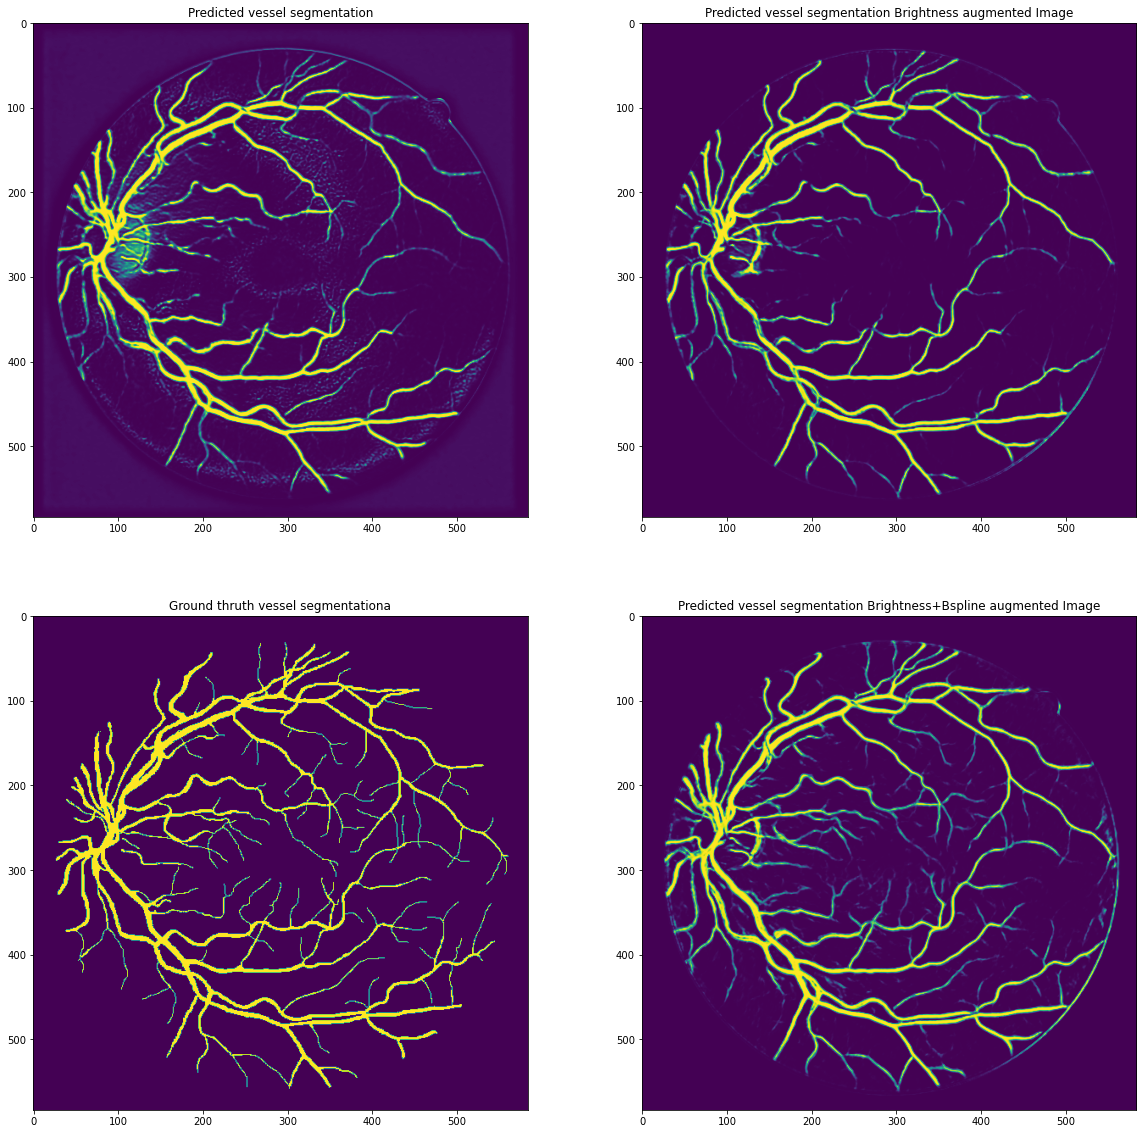

In [23]:
###load
model=tf.keras.models.load_model('partly_trained.h5')
model_2=tf.keras.models.load_model('model_bright.h5')
model_3=tf.keras.models.load_model('model_bright_bspline.h5')


# predict test samples
test_prediction = model.predict(X_test, batch_size=4)
test_prediction_2 = model_2.predict(X_test, batch_size=4)
test_prediction_3 = model_3.predict(X_test, batch_size=4)
# visualize the test result



fig, ax = plt.subplots(2,2,figsize=(20, 20))
# ax[0,0].set_title('Original Image of the retina')
# ax[0,0].imshow(test_images[0])            

ax[0,0].imshow(test_prediction[0, :, :, 0])
ax[0,0].set_title("Predicted vessel segmentation")

ax[1,0].imshow(test_segmentations[0][:, :, 0])
ax[1,0].set_title("Ground thruth vessel segmentationa")             
             
             
ax[0,1].imshow(test_prediction_2[0, :, :, 0])
ax[0,1].set_title("Predicted vessel segmentation Brightness augmented Image")

ax[1,1].imshow(test_prediction_3[0, :, :, 0])
ax[1,1].set_title("Predicted vessel segmentation Brightness+Bspline augmented Image")
             
plt.show()

1/1 [==============================] - 0s 3ms/step - loss: 2.6033 - accuracy: 0.4102
[2.603283166885376, 0.4101613759994507]
1/1 [==============================] - 0s 3ms/step - loss: 3.4616 - accuracy: 0.4037
[3.4616429805755615, 0.40368151664733887]
1/1 [==============================] - 0s 3ms/step - loss: 3.3947 - accuracy: 0.4188
[3.3947064876556396, 0.4188080430030823]


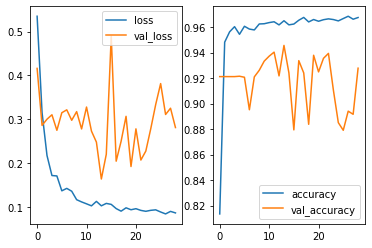

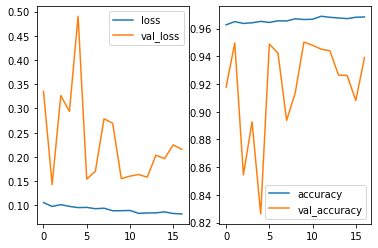

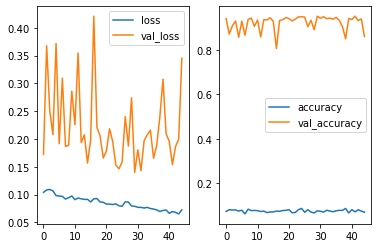

In [18]:
print(model.evaluate(X_test, y_test, verbose=1))
print(model_2.evaluate(X_test, y_test, verbose=1))
print(model_3.evaluate(X_test, y_test, verbose=1))





with open('history_baseline', 'rb') as f:
        log_1 = cPickle.load(f)


fig, ax = plt.subplots(1, 2)
ax[0].plot(log_1['loss'])
ax[0].plot(log_1['val_loss'])
ax[0].legend(['loss', 'val_loss'])
ax[1].plot(log_1['accuracy'])
ax[1].plot(log_1['val_accuracy'])
ax[1].legend(['accuracy', 'val_accuracy'])
plt.show()


with open('history_baseline_aug1', 'rb') as f:
        log_2 = cPickle.load(f)
        
fig, ax = plt.subplots(1, 2)
ax[0].plot(log_2['loss'])
ax[0].plot(log_2['val_loss'])
ax[0].legend(['loss', 'val_loss'])
ax[1].plot(log_2['accuracy'])
ax[1].plot(log_2['val_accuracy'])
ax[1].legend(['accuracy', 'val_accuracy'])
plt.show()


with open('history_baseline_aug1_aug2', 'rb') as f:
        log_3 = cPickle.load(f)
        
fig, ax = plt.subplots(1, 2)
ax[0].plot(log_3['loss'])
ax[0].plot(log_3['val_loss'])
ax[0].legend(['loss', 'val_loss'])
ax[1].plot(log_3['accuracy'])
ax[1].plot(log_3['val_accuracy'])
ax[1].legend(['accuracy', 'val_accuracy'])
plt.show()